## PE vs Monetary Cycle Analysis

### Dataset Overview
- S&P500 PE Ratio Historical Data Timeframe M www.macrotrends.net
- 10 Year Treasury Rate Historical Data Timeframe D www.macrotrends.net

### Research Question/direction:
- Exploratory Data Analysis
- Pre process and Modeling for relation analysis

## Data Assessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams.update({'font.size': 16,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6)})

In [2]:
pe_ratio = pd.read_csv('sp-500-pe-ratio-price-to-earnings-chart.csv')
pe_ratio.date = pd.to_datetime(pe_ratio.date)

bond_yield = pd.read_csv('10-year-treasury-bond-rate-yield-chart.csv')
bond_yield.date = pd.to_datetime(bond_yield.date)

In [3]:
def basic_info(df):
    print("This dataset has ", df.shape[1], " columns and ", df.shape[0], " rows.")
    print("This dataset has ", df[df.duplicated()].shape[0], " duplicated rows.")
    print(" ")
    print("Descriptive statistics of the numeric features in the dataset: ")
    print(" ")
    print(df.describe().T)
    print(" ")
    print("Information about this dataset: ")
    print(" ")
    print(df.info())

In [4]:
basic_info(pe_ratio)

This dataset has  2  columns and  1117  rows.
This dataset has  0  duplicated rows.
 
Descriptive statistics of the numeric features in the dataset: 
 
         count       mean        std  min      25%      50%      75%       max
 value  1117.0  17.362204  10.564808  5.9  11.8137  16.4858  19.5395  122.4128
 
Information about this dataset: 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1117 non-null   datetime64[ns]
 1    value  1117 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.6 KB
None


In [5]:
basic_info(bond_yield)

This dataset has  2  columns and  15097  rows.
This dataset has  0  duplicated rows.
 
Descriptive statistics of the numeric features in the dataset: 
 
          count      mean      std   min   25%   50%   75%    max
 value  15076.0  5.928265  2.99262  0.52  3.91  5.73  7.68  15.84
 
Information about this dataset: 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15097 entries, 0 to 15096
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    15097 non-null  datetime64[ns]
 1    value  15076 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 236.0 KB
None


Have some Null values but can use for relation analysis

In [6]:
df = pe_ratio.merge(right=bond_yield, how='left', on='date').fillna(method='ffill').dropna()
df.columns = ['date', 'pe_ratio', 'bond_yield']
df.set_index('date',inplace=True)
df.head()

,pe_ratio,bond_yield
date,,
1962-02-01,20.7596,4.09
1962-03-01,20.6380,3.98
1962-04-01,18.8012,3.98
1962-05-01,17.1844,3.85
1962-06-01,15.7781,3.89


## Exploratory Data Analysis

#### PE vs Bond-Yield Five-Year Rolling Correlation

<AxesSubplot:xlabel='date'>

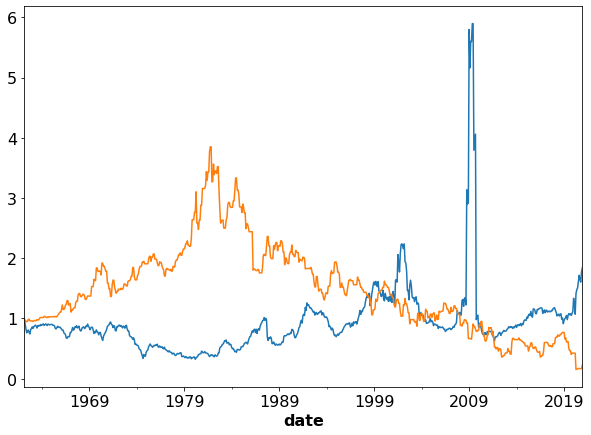

In [7]:
pe_rets = (df.pe_ratio.pct_change()+1).cumprod().dropna()
yield_rets = (df.bond_yield.pct_change()+1).cumprod().dropna()
pe_rets.plot(figsize=(10,7))
yield_rets.plot(figsize=(10,7))

<AxesSubplot:xlabel='bond_yield', ylabel='pe_ratio'>

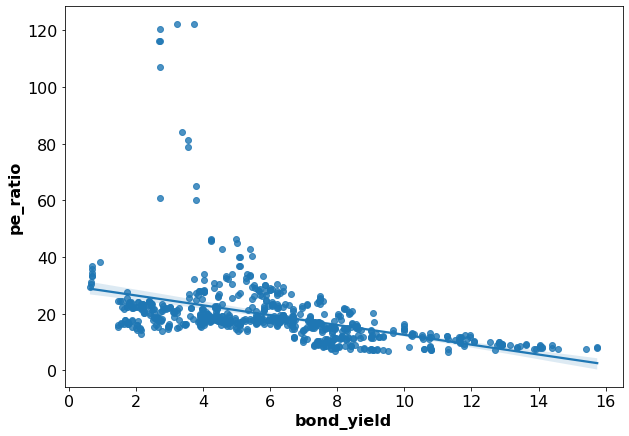

In [8]:
plt.figure(figsize=(10,7))
sns.regplot(x=df.bond_yield, y=df.pe_ratio)

#### จากรูปด้านบน มี outlier ของ PE ratio จาก Crisis ปี 2008 เเละเหตูการอื่นๆ ซึ่งทำให้มีการเปลี่ยนแปลงที่สูงอย่างรวดเร็ว

 
Five-Year Rolling Correlation Average : -0.4381978093767409
 


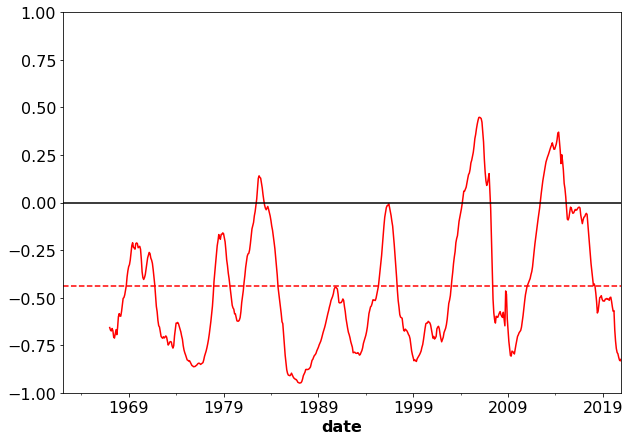

In [9]:
df['pe_ratio'].rolling(60).corr(df['bond_yield']).plot(figsize=(10,7), color = 'red')
plt.axhline(0, color = 'black')
plt.axhline(df['pe_ratio'].rolling(60).corr(df['bond_yield']).mean(), linestyle = '--', color = 'red')
plt.ylim(-1, 1)
print(' ')
print(f"Five-Year Rolling Correlation Average : {df['pe_ratio'].rolling(60).corr(df['bond_yield']).mean()}")
print(' ')

#### รูปด้านบนเเสดงถึง 5-year rolling correlation เเละข้อมูลของเราเริ่มตั้งเเต่ปี 1970, จะเห็นว่า Long Term correlation ค่อนข้างเเกว่งเเละมีค่าเฉลี่ย -0.44

## Preproscessing data

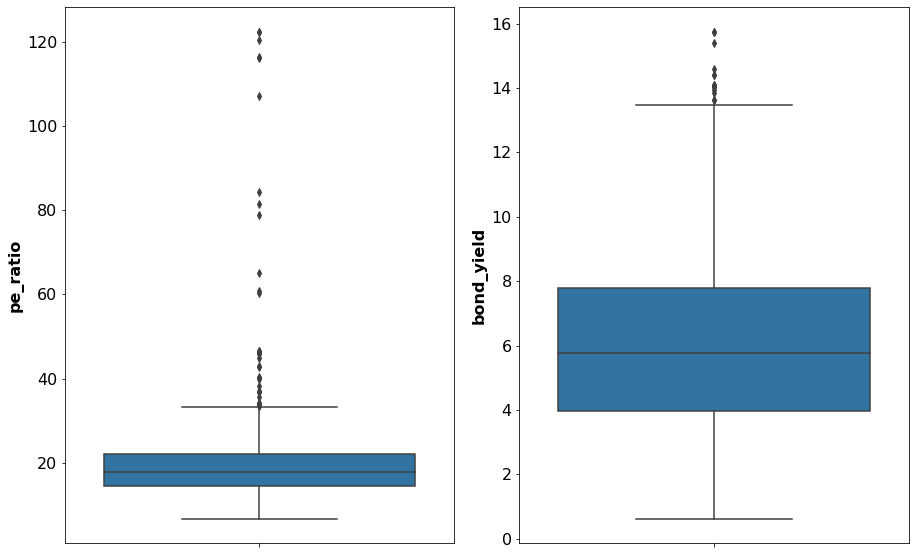

In [10]:
plt.figure(figsize=(13,8))
plt.subplot2grid((1,2),(0,0))
sns.boxplot(y=df['pe_ratio'])

plt.subplot2grid((1,2),(0,1))
sns.boxplot(y=df['bond_yield'])

plt.tight_layout()
plt.show()

#### จากรูปจะเห็นว่ามี outlier อยู่พอสมควรโดยเฉพาะ PE ratio

#### ตัดข้อมูลช่วงที่เคลื่อนไหวรุนเเรงผิดปกติซึ่งอาจจะเป็นช่วงที่เกิดวิกฤตต่างๆออก โดยคำนวน Rolling Percentchange mean เเละ std เพื่อตัด outlier ที่เกิน 3 sd

In [11]:
dfpe_rets = df[['pe_ratio']].copy()
dfyield_rets = df[['bond_yield']].copy()

dfpe_rets['pe_ratio'] = dfpe_rets['pe_ratio'].pct_change()
dfyield_rets['bond_yield'] = dfyield_rets['bond_yield'].pct_change()

dfpe_rets[['mean','sd']] = dfpe_rets.rolling(60).agg(["mean", "std"])
dfyield_rets[['mean','sd']] = dfyield_rets.rolling(60).agg(["mean", "std"])
dfpe_rets.dropna(inplace = True)
dfyield_rets.dropna(inplace = True)

In [12]:
def outlierpe_detection(df, n_sigmas = 3):
    x = df['pe_ratio']
    mu = df["mean"]
    sigma = df["sd"]
    if (x > mu + sigma*n_sigmas) | (x < mu - n_sigmas * sigma):
        return 1
    else:
        return 0
    
def outlierbond_detection(df, n_sigmas = 3):
    x = df['bond_yield']
    mu = df["mean"]
    sigma = df["sd"]
    if (x > mu + sigma*n_sigmas) | (x < mu - n_sigmas * sigma):
        return 1
    else:
        return 0    

In [13]:
dfpe_rets['outlier'] = dfpe_rets.apply(outlierpe_detection, axis=1)
dfyield_rets['outlier'] = dfyield_rets.apply(outlierbond_detection, axis=1)

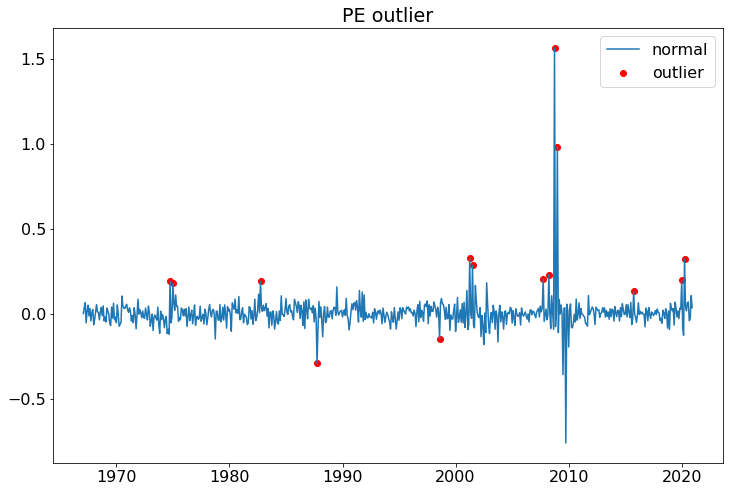

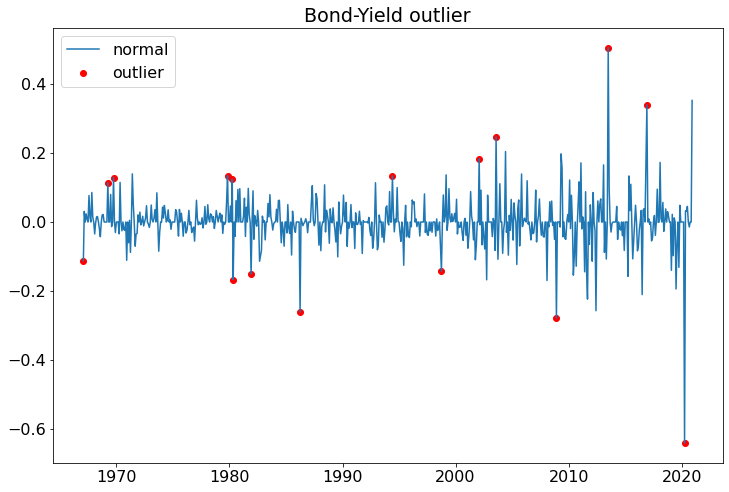

In [14]:
peoutliers = dfpe_rets.loc[dfpe_rets['outlier'] == 1, ['pe_ratio']]
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
fig, ax = plt.subplots()
ax.plot(dfpe_rets.index, dfpe_rets["pe_ratio"], label='normal')
ax.scatter(peoutliers.index, peoutliers["pe_ratio"], color="red", label="outlier")
ax.set_title(f"PE outlier")
ax.legend()
plt.show()

yieldoutliers = dfyield_rets.loc[dfyield_rets['outlier'] == 1, ['bond_yield']]
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
fig, ax = plt.subplots()
ax.plot(dfyield_rets.index, dfyield_rets["bond_yield"], label='normal')
ax.scatter(yieldoutliers.index, yieldoutliers["bond_yield"], color="red", label="outlier")
ax.set_title(f"Bond-Yield outlier")
ax.legend()
plt.show()

In [15]:
outlierdf = pd.DataFrame()
outlierdf.index = dfyield_rets.index
outlierdf['pe_ratio'] = dfpe_rets.pe_ratio
outlierdf['bond_yield'] = dfyield_rets.bond_yield
outlierdf['outlier'] = dfyield_rets.outlier + dfpe_rets.outlier

outlierdf = outlierdf.loc[outlierdf.outlier==0]
outlierdf = outlierdf.reset_index()
df = df.reset_index()

df = df.merge(outlierdf,on = 'date')
df = df[['date','pe_ratio_x','bond_yield_x']]
df.columns = ['date','pe_ratio','bond_yield']
df.set_index('date', inplace=True)

### ทีนี้เราก็ได้ data ที่ตัดช่วงวิกฤติต่างๆเรียบร้อย นำไป plot ดูกันต่อ

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pe_ratio,618.0,19.277905,12.164589,6.6769,13.281925,17.68055,22.1737,122.4128
bond_yield,618.0,6.212467,3.035151,0.6400,3.977500,6.10500,7.9200,15.7500


<AxesSubplot:xlabel='pe_ratio', ylabel='Count'>

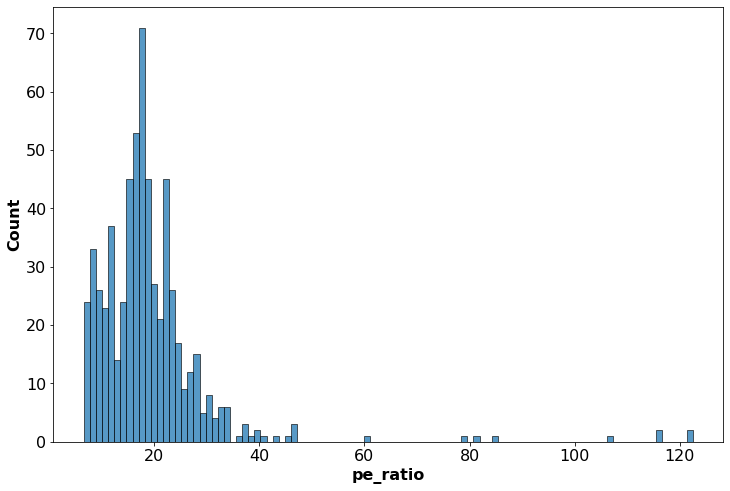

In [17]:
sns.histplot(data=df, x="pe_ratio", bins = 100)

<AxesSubplot:xlabel='bond_yield', ylabel='Count'>

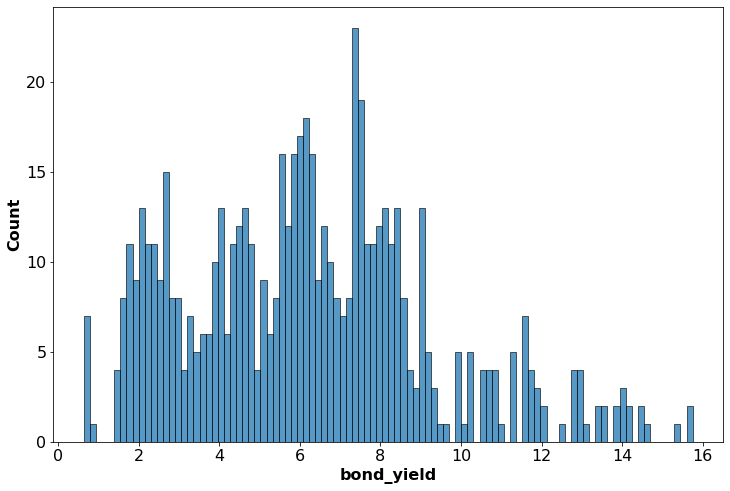

In [18]:
sns.histplot(data=df, x="bond_yield", bins = 100)

#### หลังตัด outlier ช่วงที่มีการเคลี่อนไหวรุนเเรงผิดปกติเสร็จ 
#### เราจะเห็นว่ายังเหลือช่วงที่ PE ของเรา ขึ้นไปสูงถึง 120 เท่าด้วย ซึ่งก็ไม่ปกติเช่นกัน จะเห็นhistogram เบ้เชียว
#### ตัดอีกเพื่อให้ model เสถียรขึ้น

In [19]:
df = df.loc[~((df.pe_ratio > 35) | (df.bond_yield > 12))]

## Final

<AxesSubplot:xlabel='bond_yield', ylabel='pe_ratio'>

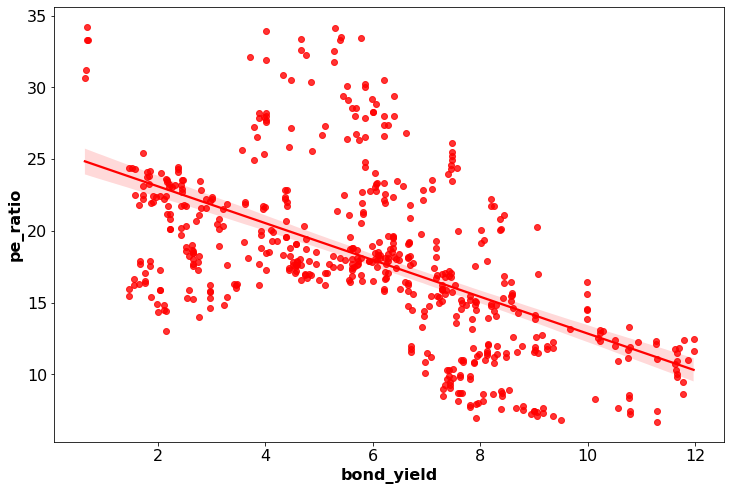

In [20]:
sns.regplot(x=df.bond_yield, y=df.pe_ratio, color='red')

In [21]:
import statsmodels.formula.api as smf
model = smf.ols(formula='pe_ratio ~ bond_yield', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pe_ratio   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     263.3
Date:                Tue, 19 Apr 2022   Prob (F-statistic):           6.97e-49
Time:                        20:25:26   Log-Likelihood:                -1703.6
No. Observations:                 567   AIC:                             3411.
Df Residuals:                     565   BIC:                             3420.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.6672      0.512     50.124      0.0

In [22]:
df['pred'] = (25.6672 + (df.bond_yield* -1.2826))
error = df.pe_ratio - df.pred
print(f"Mean Squared Error = {(error.pow(2).mean())}")
print(f"Root Mean Squared Error = {(error.pow(2).mean())**0.5}")

Mean Squared Error = 23.836815352418494
Root Mean Squared Error = 4.882296114782315


## Conclusion

#### ในสภาวะการปกติ 
#### จาก model เราสามารถอธิบายความสัมพันธ์ได้ว่า PE Ratio = 25.67 + (bond yield * -1.28)
#### P>|t| = <0.000 : statistically significant
#### R-squared = 0.318 : bond yield สามารถอธิบาย PE Ratio ได้ 31.8% เเละมี correlation = 0.318**0.5 = -0.56
#### bond_yield coef = -1.28 : มีความสัมพันธ์ในทางตรงกันข้าม เมื่อ bond yield เปลี่ยนแปลง 1 หน่วย, PE Ratio จะเปลี่ยนแปลง -1.28 หน่วย